<a href="https://colab.research.google.com/github/Hakira133/Scripts-for-aws-server-testing/blob/main/MonteCarloetf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install yfinance

     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 6.4 MB 45.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
import yfinance as yf


import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from ipywidgets import SelectionSlider

import seaborn as sns
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from multiprocessing import Pool
import multiprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from tqdm import tqdm



import warnings
warnings.filterwarnings("ignore")


def get_asset(ticker, start_date, end_date):
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)['Close']
  df = pd.DataFrame(df)
  df['return'] = df['Close'].pct_change()
  df['log_return'] = np.log(df['Close']) - np.log(df['Close'].shift(1))
  df.dropna(inplace=True)
  return df


def get_data(assets_list, start, end):
  data = []
  rejected_tickers = []

  for ticker in assets_list:
    df = get_asset(ticker, start, end)
    df.columns = [ticker+'_'+x for x in ['Close',	'return',	'log_return']]
    data.append(df)
      
  data = pd.concat(data, axis=1)  

  return data  


def get_prices(data):
  cols = [x for x in data.columns if ('Close' in x ) and ('XLC' not in x ) and ('XLRE' not in x )]
  prices = data[cols]
  prices.columns = [x.split('_')[0] for x in prices.columns]
  return prices



In [5]:
ETF = ['XLF', 'XLI', 'XLP', 'XLY', 'XLK', 'XLU', 'XLB', 'XLC', 'XLE', 'XLRE', 'XLV']
START = '2002-01-01'
END = '2020-01-01'

In [6]:
data = get_data(ETF, START, END)  
spy = get_asset("SPY", START, END)

prices = get_prices(data)
prices.head()

,XLF,XLI,XLP,XLY,XLK,XLU,XLB,XLE,XLV
Date,,,,,,,,,
2002-01-03,21.486595,27.690001,25.230000,28.60,25.680000,28.580000,21.980000,26.340000,27.299999
2002-01-04,21.770918,27.700001,25.160000,29.07,25.840000,28.450001,22.400000,26.459999,27.620001
2002-01-07,21.714054,27.510000,24.969999,28.90,25.559999,28.480000,22.400000,26.450001,27.650000
2002-01-08,21.413485,27.430000,24.840000,29.00,25.750000,28.129999,22.020000,26.219999,27.799999
2002-01-09,21.527214,27.280001,24.930000,28.60,25.549999,27.879999,21.889999,26.250000,27.650000


In [7]:
def plot_prices(asset_prices):
    ap_normed = prices[1:] / prices.iloc[0]

    plt.figure(figsize=(15,10))
    for t in tickers:
        plt.plot(ap_normed[t])

    plt.legend(asset_prices.columns)
    plt.title('Asset Curves ({} - {})'.format(start_date, end_date))

    
def portfolio_metrics(*params):
    w = params[:len(tickers)]

    portfolio_returns = np.array(prices.pct_change().multiply(w, axis=1).sum(axis=1))
    portfolio_returns[0] = 0.0

    market_returns = np.array(index_prices.pct_change()).squeeze()
    market_returns[0] = 0.0

    equity_portfolio = np.cumprod(1.0 + portfolio_returns)
    equity_market = np.cumprod(1.0 + market_returns)

    p_return = equity_portfolio[-1] / equity_portfolio[0] - 1
    m_return = equity_market[-1] / equity_market[0] - 1
    num_years = len(market_returns) / 252.0
    e_pr = p_return ** (1 / num_years) - 1
    e_m = m_return ** (1 / num_years) - 1

    beta = np.cov(portfolio_returns, market_returns)[0, 1] / np.var(market_returns)
    er = risk_free_rate + beta * (e_m - risk_free_rate)
    alpha = e_pr - er

    return (alpha, beta, p_return, m_return, equity_portfolio, equity_market, int(params[-1]))


def weights_choice(num_portfolios):
    mc_portfolios = np.zeros((num_portfolios, len(tickers)))

    num_satisfied_portfolios  = 0

    values = [0.01*k for k in range(1, 31)]
    set_weights = set()
    tmp = []
    counter = 0
    while (num_satisfied_portfolios != num_portfolios):
            weights = tuple(np.random.choice(values, 9))

            if np.sum(weights) == 1:
                if weights not in set_weights: 
                    set_weights.add(weights)
                    counter = 0
                    mc_portfolios[num_satisfied_portfolios, :len(tickers)] = weights
                    num_satisfied_portfolios = num_satisfied_portfolios + 1
                else:
                    counter += 1

                if counter > 10000:
                    break

    return mc_portfolios


def mc_simulation(num_portfolios):
    mc_portfolios = np.zeros((num_portfolios, len(tickers) + 3))

    num_satisfied_portfolios = 0
    while (num_satisfied_portfolios != num_portfolios):
        weights = np.array(np.random.random(len(tickers)))
        weights = weights / np.sum(weights)
        if np.sum(weights < min_weight_asset) == 0 and np.sum(weights > max_weight_asset) == 0:
            mc_portfolios[num_satisfied_portfolios, :len(tickers)] = weights
            num_satisfied_portfolios = num_satisfied_portfolios + 1

    params = ()
    for p in range(0, num_portfolios):
        params = ((np.append(mc_portfolios[p, :len(tickers)], [p])),) + params

    with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
        metrics = p.starmap(portfolio_metrics, params)

    for i in range(0, len(metrics)):
        ind = metrics[i][-1]
        mc_portfolios[ind, -3] = metrics[i][0]
        mc_portfolios[ind, -2] = metrics[i][1]
        mc_portfolios[ind, -1] = metrics[i][2]

    mc_portfolios_df = pd.DataFrame(mc_portfolios, columns=tickers + ['alpha', 'beta', 'return'])
    return mc_portfolios_df.sort_values('alpha', ascending=False)

def mc_simulation_choice(num_portfolios):
    mc_portfolios = np.zeros((num_portfolios, len(tickers) + 3))

    num_satisfied_portfolios  = 0

    values = [0.01*k for k in range(1, 31)]
    set_weights = set()
    tmp = []
    counter = 0
    while (num_satisfied_portfolios != num_portfolios):
            weights = tuple(np.random.choice(values, 9))

            if np.sum(weights) == 1:
                if weights not in set_weights: 
                    set_weights.add(weights)
                    counter = 0
                    mc_portfolios[num_satisfied_portfolios, :len(tickers)] = weights
                    num_satisfied_portfolios = num_satisfied_portfolios + 1
                else:
                    counter += 1

                if counter > 10000:
                    break

    params = ()
    for p in range(0, num_portfolios):
        params = ((np.append(mc_portfolios[p, :len(tickers)], [p])),) + params

    with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
        metrics = p.starmap(portfolio_metrics, params)

    for i in range(0, len(metrics)):
        ind = metrics[i][-1]
        mc_portfolios[ind, -3] = metrics[i][0]
        mc_portfolios[ind, -2] = metrics[i][1]
        mc_portfolios[ind, -1] = metrics[i][2]

    mc_portfolios_df = pd.DataFrame(mc_portfolios, columns=tickers + ['alpha', 'beta', 'return'])
    return mc_portfolios_df.sort_values('alpha', ascending=False)


def calculate_portfolio(weights):
    num_portfolios = len(weights)
    mc_portfolios = np.zeros((num_portfolios, len(tickers) + 3))
    
    for i in range(num_portfolios):
        mc_portfolios[i, :len(tickers)] = weights[i]
    
    params = ()
    for p in range(0, num_portfolios):
        params = ((np.append(mc_portfolios[p, :len(tickers)], [p])),) + params

    with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
        metrics = p.starmap(portfolio_metrics, params)

    for i in range(0, len(metrics)):
        ind = metrics[i][-1]
        mc_portfolios[ind, -3] = metrics[i][0]
        mc_portfolios[ind, -2] = metrics[i][1]
        mc_portfolios[ind, -1] = metrics[i][2]

    mc_portfolios_df = pd.DataFrame(mc_portfolios, columns=tickers + ['alpha', 'beta', 'return'])
    return mc_portfolios_df.sort_values('alpha', ascending=False)


def define_num_clusters(min_val, max_val):
    item_multiplier = 1000
    if min_good_alpha != 0:
        item_multiplier = 1.0 / min_good_alpha
        
    print('item_multiplier ', item_multiplier)

    good_portfolios = mc_result[mc_result.alpha > min_good_alpha]
    X = pd.DataFrame()

    # Размножаем значения относительно значения alpha в точке
    for i in range(0, good_portfolios.shape[0]):
        #print(int(round(item_multiplier * good_portfolios['alpha'].iloc[i])))
        X = X.append([good_portfolios[tickers].iloc[i]] * int(round(item_multiplier * good_portfolios['alpha'].iloc[i])))

    mms = MinMaxScaler()
    mms.fit(X)
    X_transformed = mms.transform(X)

    sum_of_squared_distances = []
    silhouette_scores = []
    num_clusters = range(min_val, max_val)

    for k in tqdm(num_clusters):
        km = KMeans(n_clusters = k, random_state = 100)
        km = km.fit(X_transformed)

        silhouette_scores.append(silhouette_score(X_transformed, km.labels_, metric = 'euclidean'))
        sum_of_squared_distances.append(km.inertia_)

    k = num_clusters[np.argmax(silhouette_scores)]
    print('Optimal number of clusters: ' + str(k))

    sns.set(rc = {'figure.figsize':(15, 10)})
    plt.plot(num_clusters, sum_of_squared_distances, 'bx-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.show()

    plt.plot(num_clusters, silhouette_scores, 'bx-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score of Clusters')
    plt.show()

    return k, mms, X_transformed, good_portfolios

def do_cluster_analysis(k, mms, X_transformed, good_portfolios):
    km = KMeans(n_clusters = k, random_state = 100)
    km = km.fit(X_transformed)
    cluster_centers = mms.inverse_transform(km.cluster_centers_)

    mean_cols = [str(col) for col in tickers]
    df_result = pd.DataFrame(columns = mean_cols, data = cluster_centers)
    df_result['num_objects'] = [0.0] * df_result.shape[0]
    df_result['avg_alpha'] = [0.0] * df_result.shape[0]

    tmp_transformed = mms.transform(good_portfolios[tickers])
    for i in range(0, df_result.shape[0]):
        clusted_ind = km.predict(tmp_transformed) == i
        df_result['num_objects'][i] = np.sum(clusted_ind)
        df_result['avg_alpha'][i] = np.mean(good_portfolios['alpha'][clusted_ind])

    return df_result

def get_best_solutions(clusters, num_clusters, mc_best):
    asset_returns = prices.pct_change()
    asset_returns.iloc[0] = 0.0

    best_portfolios = pd.DataFrame(columns = [range(0, num_clusters)].append([index_ticker]), index=prices.index)
    for i in range(0, clusters.shape[0]):
        w = clusters.iloc[i][tickers]
        portfolio_returns = asset_returns.multiply(w, axis=1).sum(axis=1)
        equity_portfolio = np.cumprod(1.0 + portfolio_returns)
        best_portfolios[i] = equity_portfolio
    best_portfolios[index_ticker] = mc_best[5]

    best_portfolios.plot()
    plt.legend()
    plt.title('Best solutions vs. Index ({} - {})'.format(start_date, end_date))

    return best_portfolios

def sortino_ratio(returns):
    losses = returns[returns <= 0]
    downside_deviation = np.std(losses)

    return np.mean(returns) / downside_deviation * np.sqrt(252)

def rolling_sortino_portfolio(portfolios):
    rolled_sortino = pd.DataFrame()
    port_returns = portfolios.pct_change().dropna()

    for p in portfolios.columns:
        rolled_sortino[p] = port_returns[p].rolling(rolled_sortino_period).apply(sortino_ratio)
    return rolled_sortino

def get_maxdd(prices_series):
    roll_max = [prices_series[prices_series.index[0]]]
    for x in prices_series[prices_series.index[1]:]:
        roll_max.append(max(x, roll_max[-1]))

    dd = prices_series/roll_max - 1.0 
    return dd.min(), prices_series.index[np.argmin(dd)]


def get_profit(returns_series):
    profit=(returns_series+1).cumprod()
    return profit.values[-1] - 1


def get_sharpe_ratio(returns_series):
    sharpe_ratio = returns_series.mean()/returns_series.std()

    #annualized sharpe ratio
    asr = sharpe_ratio*252**.5 
    return asr, sharpe_ratio


def create_neighbor_vectors(vector, deltas):
    vectors = []
    #print(vector)
    #print(len(vector))
    for i in range(len(vector)-1):
        for j in range(i+1, len(vector)):
            for k in deltas:
                b = vector.copy()
                b[i] = b[i] + k
                b[j] = b[j] - k
                if (b[i] >= 0) and (b[j] >= 0):
                    vectors.append(b)
    return vectors


# WFA

In [8]:
tickers = ['XLF', 'XLI', 'XLP', 'XLY', 'XLK', 'XLU', 'XLB', 'XLE', 'XLV']
index_ticker = 'SPX'

num_simulations = 10000
min_weight_asset = 0.01
max_weight_asset = 0.26
min_good_alpha = 0.005
rolled_sortino_period = 63

In [ ]:
num_simulations = 10000
mc_weights = weights_choice(num_simulations)

In [ ]:
start_date = pd.to_datetime('2005-01-01') #"2004-07-01"
end_date = pd.to_datetime('2015-01-01')

data = get_data(tickers, start_date, end_date)  
prices = get_prices(data)
spy = get_asset("SPY",start_date, end_date)['Close']


spy


Date
2005-01-04    118.830002
2005-01-05    118.010002
2005-01-06    118.610001
2005-01-07    118.440002
2005-01-10    119.000000
                 ...    
2014-12-24    207.770004
2014-12-26    208.440002
2014-12-29    208.720001
2014-12-30    207.600006
2014-12-31    205.539993
Name: Close, Length: 2516, dtype: float64

In [ ]:
%%time
start_date = pd.to_datetime('2005-01-01') #"2004-07-01"
end_date = pd.to_datetime('2015-01-01')
risk_free_rate = 0.025
best_w = []
best_clusters = []
years = []
#num_simulations = 20000

step = datetime.timedelta(days = 370)

#mc_weights = weights_choice(num_simulations)

while end_date <= datetime.datetime(2016,1,1):
    print(f'Period {start_date} - {end_date}') 
    years.append(end_date)

    data = get_data(tickers, start_date, end_date)  
    prices = get_prices(data)

    prices.columns = tickers
    index_prices = get_asset("SPY",start_date, end_date)['Close']  

    mc_base =  calculate_portfolio(mc_weights)

    thresh = np.quantile(mc_base.alpha, .98)
    print(thresh)
    additional_weights = mc_base[mc_base.alpha>thresh]
    print(additional_weights.alpha.min())

#     #deltas = [.02, .015, .01, 0.005, -.005, -.01, -.015, -.02]
#     deltas = [.01, -.01]
#     add_w = []
#     for w in additional_weights.loc[:, tickers].values:
#         add_w += create_neighbor_vectors(list(w), deltas) 

#     print(len(add_w))
#     add_w = pd.DataFrame(add_w).drop_duplicates().values.tolist()    
#     print(f'Calculating add_w portf ({len(add_w)})')
#     add_portfolios = calculate_portfolio(add_w)

#    mc_result = pd.concat([mc_base, add_portfolios])
    mc_result =  mc_base.drop_duplicates()#mc_result.drop_duplicates()

    #print(mc_result.sort_values(by='alpha', ascending=False).head(3))
    w_best = mc_result.sort_values(by='alpha', ascending=False).iloc[0][:len(tickers)].values.tolist()
    print(f'w_best = {w_best}')
    best_w.append(w_best)
    
    #start_date = start_date.replace(year = start_date.year + 1)
    #end_date = end_date.replace(year = end_date.year + 1)
    
    start_date = start_date + step
    end_date = end_date + step
    print('\n---------------------')

Period 2005-01-01 00:00:00 - 2015-01-01 00:00:00
0.044780733060150714
0.04481039282227227
w_best = [0.02, 0.04, 0.03, 0.25, 0.13, 0.01, 0.02, 0.25, 0.25]

---------------------
CPU times: user 1.82 s, sys: 1.61 s, total: 3.43 s
Wall time: 31.3 s


In [ ]:
wght = pd.DataFrame(best_w, index = years)
#wght = wght.set_index('year')#.drop(9, axis=1)
wght.columns = tickers

date_range = pd.date_range(start=wght.index.min(), end=datetime.datetime(2022,1,1))
wght = wght.reindex(index=date_range)
wght = wght.fillna(method='ffill')
wght

In [ ]:
start_date = pd.to_datetime('2015-01-01') #"2004-07-01"
end_date = pd.to_datetime('2022-01-02')
prices = data[start_date: end_date]
prices.columns = tickers
retns = prices.pct_change().dropna()
wght = wght[wght.index.isin(retns.index)]


best_portfolio_returns = retns.multiply(wght)#pd.concat(results, axis=0)
best_portfolio_returns = best_portfolio_returns.sum(axis=1)

In [ ]:
%%time

index_prices = spx.loc[best_portfolio_returns.index, 'SPX']
Index = pd.Series(np.cumprod(1.0 + best_portfolio_returns), 
                     index = best_portfolio_returns.index)

profit = [(index_prices/index_prices[0]).values[-1]]
max_dd =  [get_maxdd(index_prices)[0]]
max_dd_date = [get_maxdd(index_prices)[1]]
sharpe =  [get_sharpe_ratio(index_prices.pct_change())[0]]


f,ax = plt.subplots(figsize = (18,6))

ax.plot(Index, label = f'Index{i}')

profit.append(Index.values[-1])
max_dd.append(get_maxdd(Index)[0])
max_dd_date.append(get_maxdd(Index)[1])
sharpe.append(get_sharpe_ratio(Index.pct_change())[0])
    
ax.plot(index_prices/index_prices[0], label = 'SPX')
ax.legend()

pd.DataFrame({
    'Profit': profit,
    'Max_dd': max_dd,
    'Max_dd_date': max_dd_date,
    'Sharpe': sharpe},
    index = ['SPX'] + [f'best index'])

# Cluster WFA

In [9]:
num_simulations = 20000
mc_weights = weights_choice(num_simulations)

In [10]:
len(mc_weights)

20000

Period 2005-01-01 00:00:00 - 2018-01-01 00:00:00
alpha thresh = 0.026966916919964154
26960
Calculating add_w portf (26960)
w_best = [0.0, 0.01, 0.08, 0.21, 0.31, 0.03, 0.02, 0.07, 0.27]
item_multiplier  66.66666666666667


100%|██████████| 1/1 [01:19<00:00, 79.14s/it]


Optimal number of clusters: 20


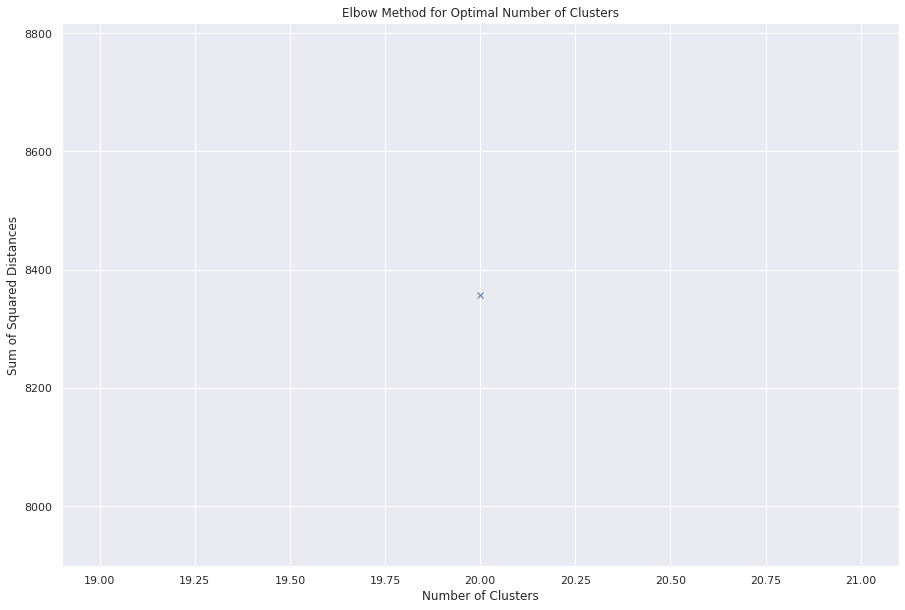

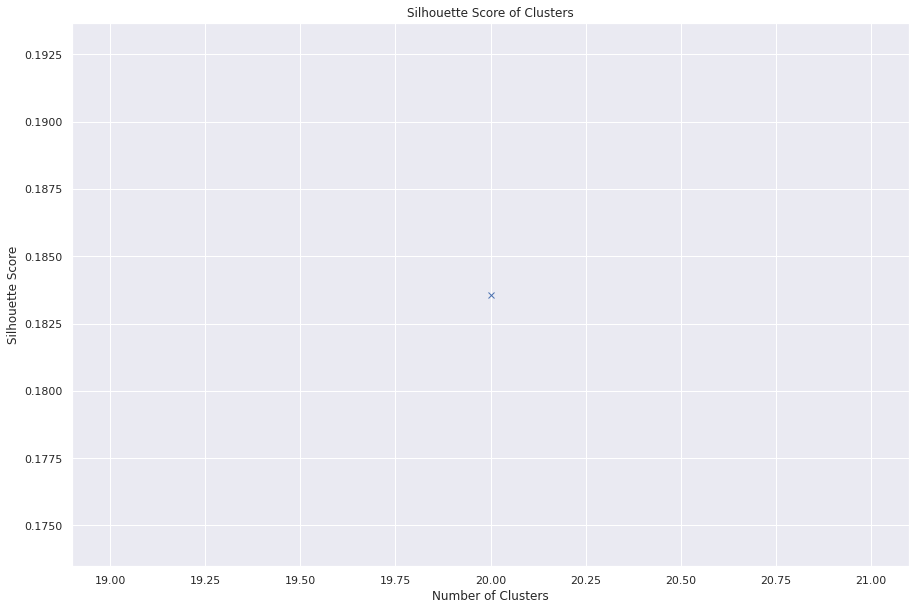

----------------------------

Period 2006-01-02 00:00:00 - 2019-01-02 00:00:00
alpha thresh = 0.02994389225332601
27096
Calculating add_w portf (27096)
w_best = [0.01, 0.04, 0.09, 0.29000000000000004, 0.25, 0.01, 0.06, 0.0, 0.25]
item_multiplier  66.66666666666667


100%|██████████| 1/1 [01:07<00:00, 67.18s/it]


Optimal number of clusters: 20


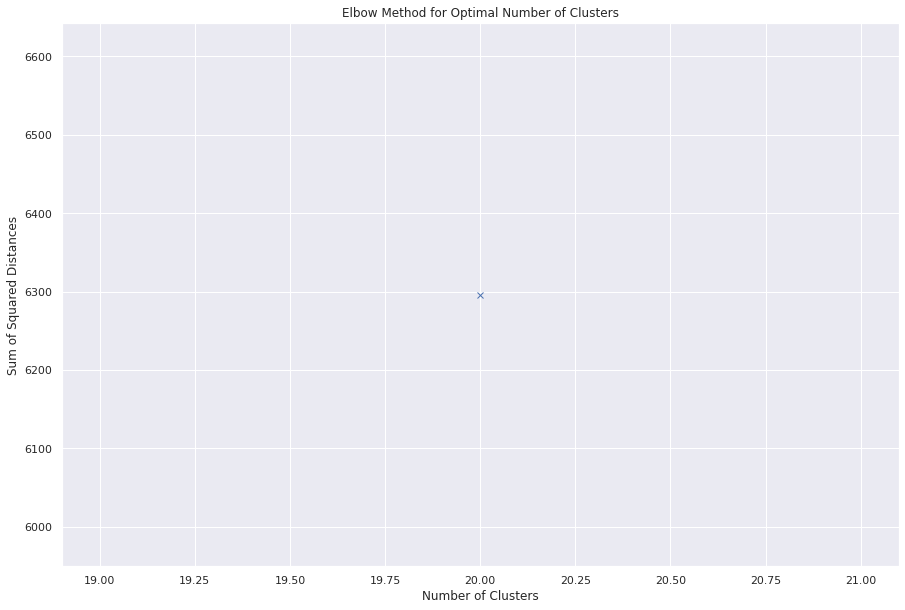

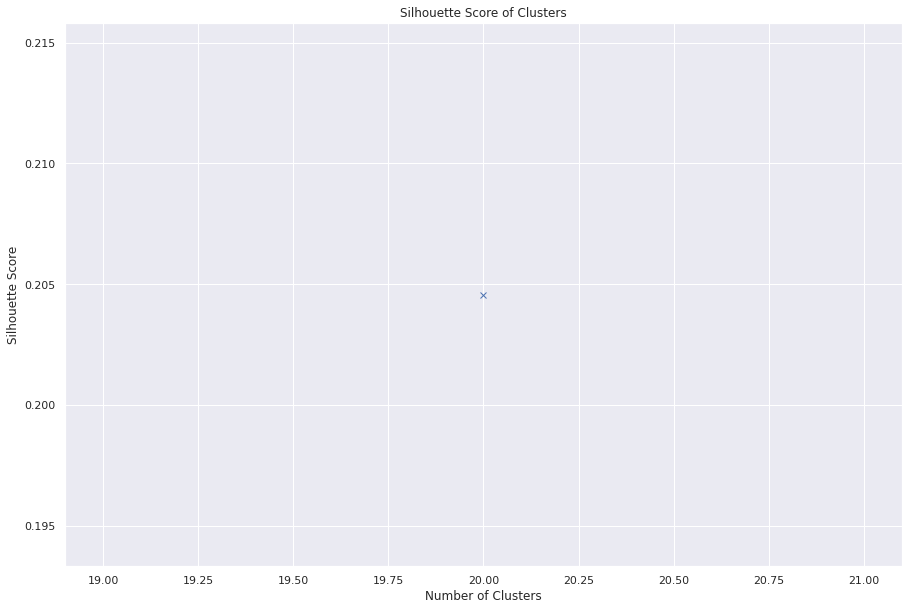

----------------------------

Period 2007-01-03 00:00:00 - 2020-01-03 00:00:00
alpha thresh = 0.028193645344445437
27080
Calculating add_w portf (27080)
w_best = [0.01, 0.04, 0.09, 0.27, 0.27, 0.01, 0.06, 0.0, 0.25]
item_multiplier  66.66666666666667


100%|██████████| 1/1 [01:05<00:00, 65.39s/it]


Optimal number of clusters: 20


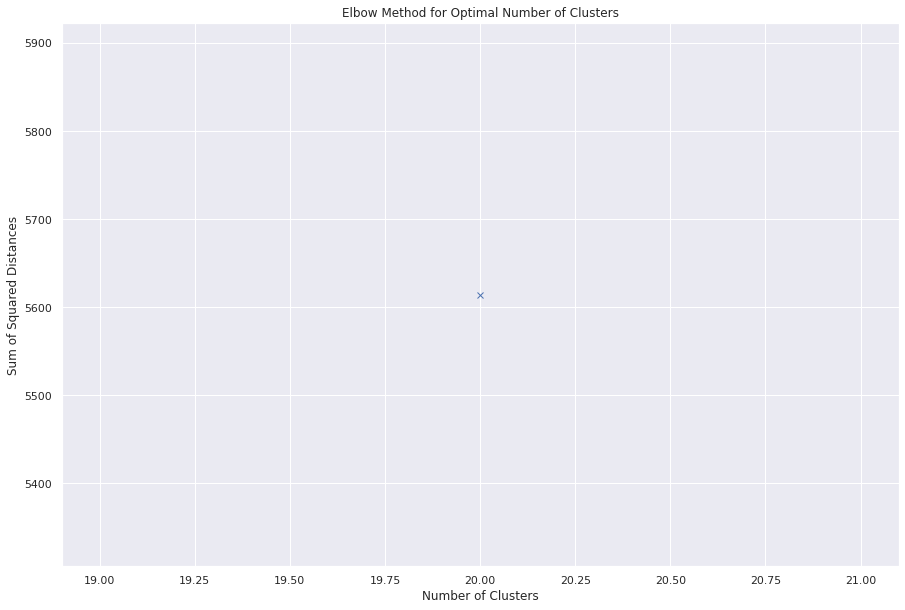

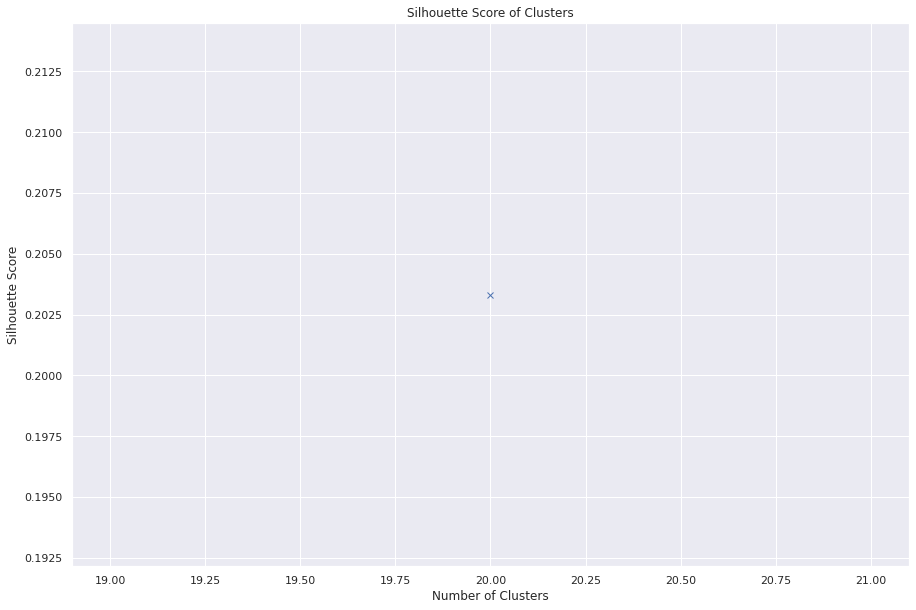

----------------------------

Period 2008-01-04 00:00:00 - 2021-01-03 00:00:00
alpha thresh = 0.02794782448579966
27088
Calculating add_w portf (27088)
w_best = [0.01, 0.04, 0.09, 0.27, 0.27, 0.01, 0.06, 0.0, 0.25]
item_multiplier  66.66666666666667


100%|██████████| 1/1 [01:06<00:00, 66.72s/it]


Optimal number of clusters: 20


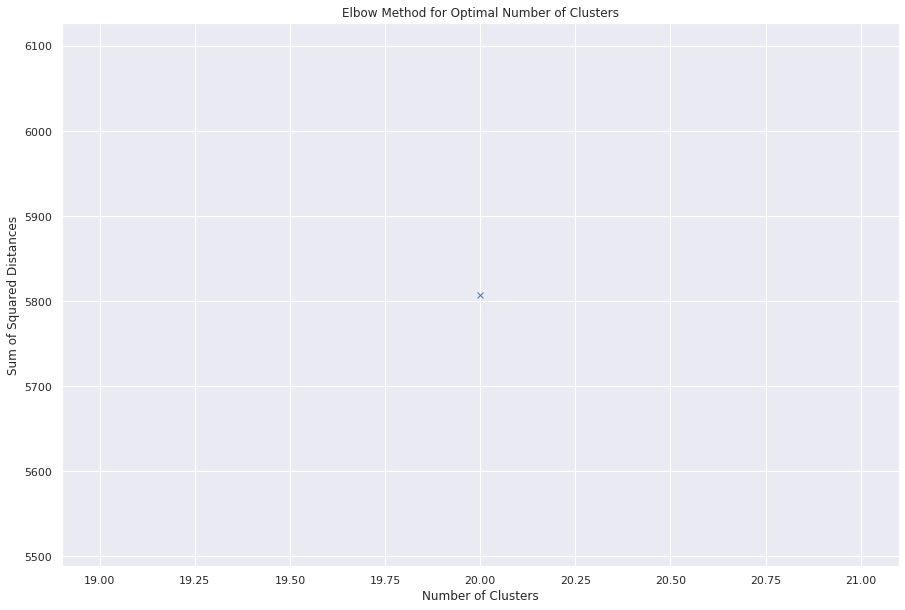

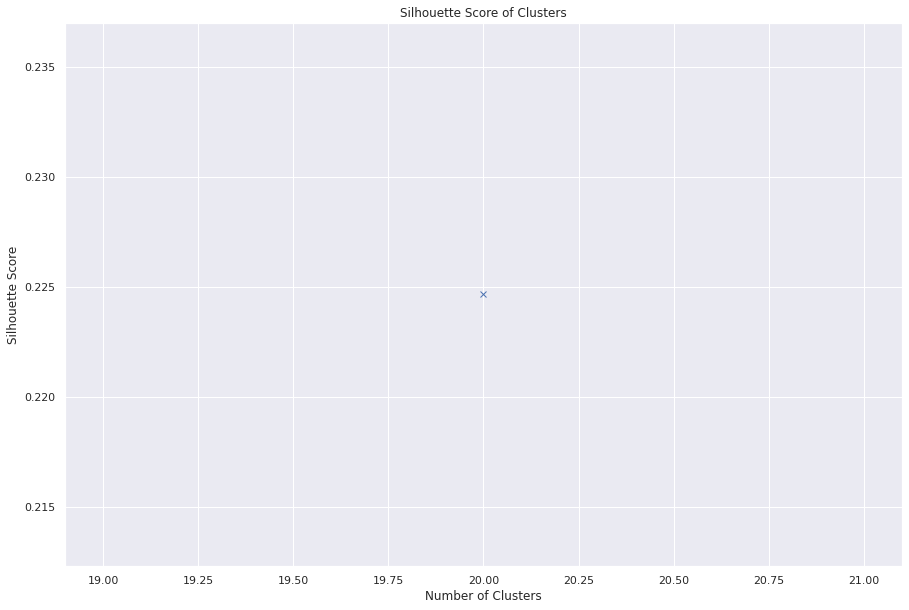

----------------------------

CPU times: user 15min 17s, sys: 2min 46s, total: 18min 4s
Wall time: 25min 29s


In [11]:
%%time
start_date = pd.to_datetime('2005-01-01') #"2004-07-01"
end_date = pd.to_datetime('2018-01-01')
risk_free_rate = 0.025
best_w = []
best_clusters = []
years = []

min_val, max_val = 20, 21
min_good_alpha = 0.015

step = datetime.timedelta(days = 366)

#num_simulations = 20000
#mc_weights = weights_choice(num_simulations)

while end_date <= datetime.datetime(2022,1,1):
    print(f'Period {start_date} - {end_date}') 
    years.append(end_date)

    data = get_data(tickers, start_date, end_date)  
    prices = get_prices(data)

    prices.columns = tickers
    index_prices = get_asset("SPY",start_date, end_date)['Close']  

    mc_base =  calculate_portfolio(mc_weights)

    thresh = np.quantile(mc_base.alpha, .99)
    #print(thresh)
    additional_weights = mc_base[mc_base.alpha>thresh]
    print(f'alpha thresh = {additional_weights.alpha.min()}')

    #deltas = [.02, .015, .01, 0.005, -.005, -.01, -.015, -.02]
    deltas = [.02, .01, -.01,  -.02]
    add_w = []
    for w in additional_weights.loc[:, tickers].values:
        add_w += create_neighbor_vectors(list(w), deltas) 

    print(len(add_w))
    add_w = pd.DataFrame(add_w).drop_duplicates().values.tolist()    
    print(f'Calculating add_w portf ({len(add_w)})')
    add_portfolios = calculate_portfolio(add_w)

    mc_result = pd.concat([mc_base, add_portfolios])
    mc_result = mc_result.drop_duplicates()

    w_best = mc_result.sort_values(by='alpha', ascending=False).iloc[0][:len(tickers)].values.tolist()
    print(f'w_best = {w_best}')
    best_w.append(w_best)
    
    num_clusters, scaler, X_trans, good_portfolios = define_num_clusters(min_val, max_val)
    clusters = do_cluster_analysis(num_clusters, scaler, X_trans, good_portfolios)
    best_clusters.append(clusters)
    
    start_date = start_date + step
    end_date = end_date + step
    print('----------------------------\n')

In [12]:
W_cl = []
for x in best_clusters:
    W_cl.append(x.sort_values(by='avg_alpha', ascending=False)[tickers].values.tolist()[0])
W_cl

[[0.03475312934631434,
  0.02300069541028969,
  0.07761821974965213,
  0.2485500695410245,
  0.24460361613351886,
  0.03777121001390814,
  0.03261474269819203,
  0.051884561891516266,
  0.24920375521557503],
 [0.025230419508162957,
  0.046519942136804715,
  0.07239925604463707,
  0.2308266170696437,
  0.21873527588344943,
  0.03826203761107784,
  0.06768133911965285,
  0.03538334366604678,
  0.26496176896053264],
 [0.021075388026607165,
  0.034031042128604236,
  0.08804656319290423,
  0.22780044345898243,
  0.238374722838137,
  0.045736141906874084,
  0.05355432372505569,
  0.0388248337028824,
  0.2525565410199556],
 [0.04307893361212754,
  0.15680083638264627,
  0.03227391531625582,
  0.2537062205959223,
  0.22396236278097234,
  0.0378410872974386,
  0.035927861996863056,
  0.018029273392576987,
  0.19837950862519818]]

In [13]:
wght = pd.DataFrame(W_cl, index = years)
#wght = wght.set_index('year')#.drop(9, axis=1)
wght.columns = tickers

date_range = pd.date_range(start=wght.index.min(), end=datetime.datetime(2022,1,1))
wght = wght.reindex(index=date_range)
wght = wght.fillna(method='ffill')
wght

,XLF,XLI,XLP,XLY,XLK,XLU,XLB,XLE,XLV
2018-01-01,0.034753,0.023001,0.077618,0.248550,0.244604,0.037771,0.032615,0.051885,0.249204
2018-01-02,0.034753,0.023001,0.077618,0.248550,0.244604,0.037771,0.032615,0.051885,0.249204
2018-01-03,0.034753,0.023001,0.077618,0.248550,0.244604,0.037771,0.032615,0.051885,0.249204
2018-01-04,0.034753,0.023001,0.077618,0.248550,0.244604,0.037771,0.032615,0.051885,0.249204
2018-01-05,0.034753,0.023001,0.077618,0.248550,0.244604,0.037771,0.032615,0.051885,0.249204
...,...,...,...,...,...,...,...,...,...
2021-12-28,0.043079,0.156801,0.032274,0.253706,0.223962,0.037841,0.035928,0.018029,0.198380
2021-12-29,0.043079,0.156801,0.032274,0.253706,0.223962,0.037841,0.035928,0.018029,0.198380
2021-12-30,0.043079,0.156801,0.032274,0.253706,0.223962,0.037841,0.035928,0.018029,0.198380
2021-12-31,0.043079,0.156801,0.032274,0.253706,0.223962,0.037841,0.035928,0.018029,0.198380


In [19]:
wght.to_csv('Coeff Index higher SNP from 18 366day rebalance.csv')

In [17]:
start_date = pd.to_datetime('2018-01-01') #"2004-07-01"
end_date = pd.to_datetime('2022-01-02')
#prices = data[start_date: end_date]
#prices.columns = tickers

data = get_data(tickers, start_date, end_date)  
prices = get_prices(data)

prices.columns = tickers
index_prices = get_asset("SPY",start_date, end_date)['Close']  


retns = prices.pct_change().dropna()
wght = wght[wght.index.isin(retns.index)]


best_portfolio_returns = retns.multiply(wght)#pd.concat(results, axis=0)
best_portfolio_returns = best_portfolio_returns.sum(axis=1)

              Profit    Max_dd Max_dd_date    Sharpe
SPX         1.756054 -0.341047  2020-03-23  0.779866
best index  1.849136 -0.328331  2020-03-23  0.842426
CPU times: user 63.8 ms, sys: 0 ns, total: 63.8 ms
Wall time: 130 ms


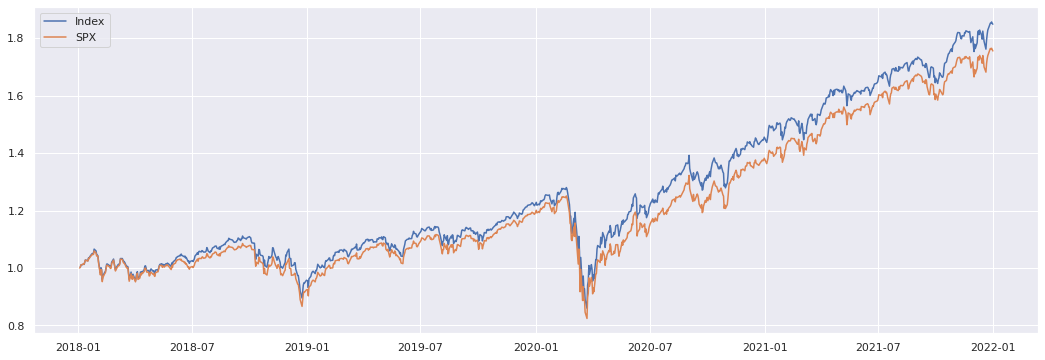

In [21]:
%%time

#index_prices = spx.loc[best_portfolio_returns.index, 'SPX']
Index = pd.Series(np.cumprod(1.0 + best_portfolio_returns), 
                     index = best_portfolio_returns.index)

profit = [(index_prices/index_prices[0]).values[-1]]
max_dd =  [get_maxdd(index_prices)[0]]
max_dd_date = [get_maxdd(index_prices)[1]]
sharpe =  [get_sharpe_ratio(index_prices.pct_change())[0]]


f,ax = plt.subplots(figsize = (18,6))

ax.plot(Index, label = f'Index')

profit.append(Index.values[-1])
max_dd.append(get_maxdd(Index)[0])
max_dd_date.append(get_maxdd(Index)[1])
sharpe.append(get_sharpe_ratio(Index.pct_change())[0])
    
ax.plot(index_prices/index_prices[0], label = 'SPX')
ax.legend()

res = pd.DataFrame({
    'Profit': profit,
    'Max_dd': max_dd,
    'Max_dd_date': max_dd_date,
    'Sharpe': sharpe},
    index = ['SPX'] + [f'best index'])
print(res)